183.313731

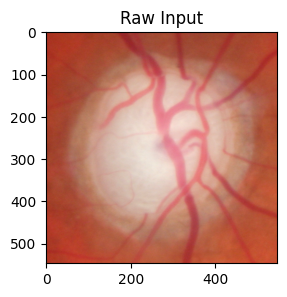

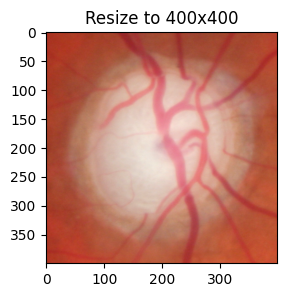

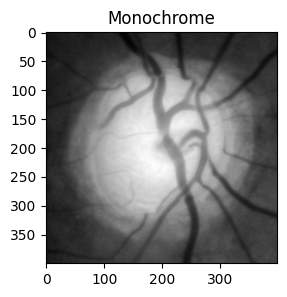

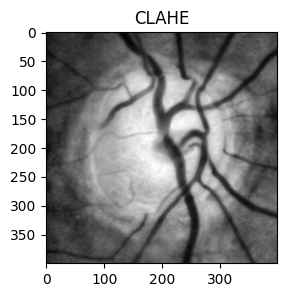

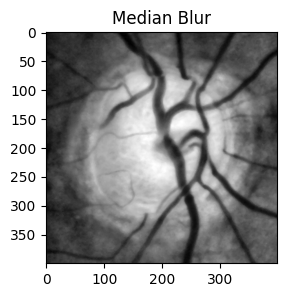

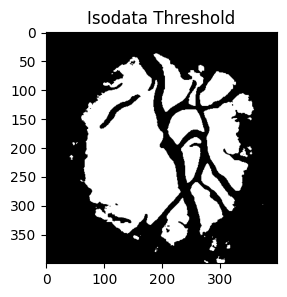

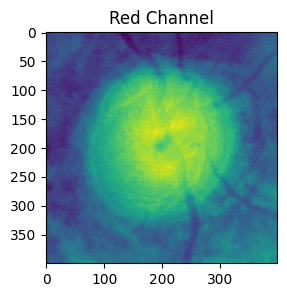

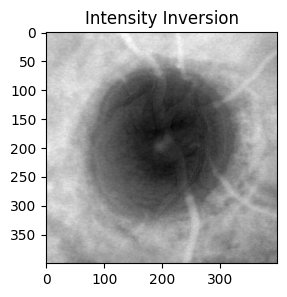

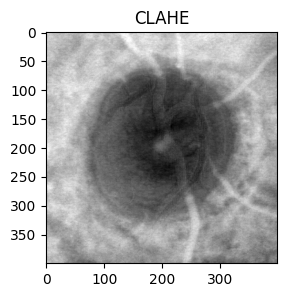

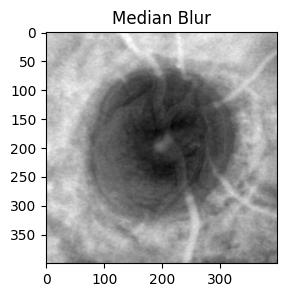

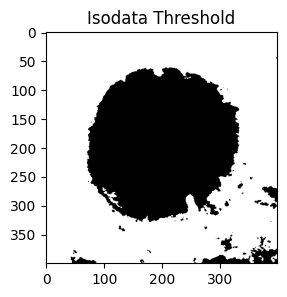

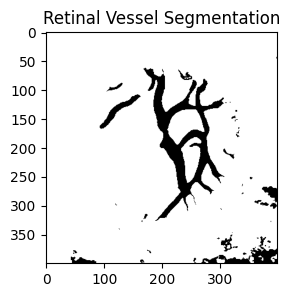

In [26]:
from skimage import color, io, filters, morphology, exposure, draw, img_as_float, transform
import numpy as np
import cv2
import math
import statistics
import matplotlib.pyplot as plt

MASK_SHAPE = "t"

def findCentroid(img):
    # Calculate centroid (vp = vessel pixel)
    vpTotal = 0
    vpX = 0
    vpY = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 0:
                vpTotal += 1
                vpX += i
                vpY += j

    return [(vpX / vpTotal), (vpY / vpTotal)]

# To minimize code, we can encapsulate what we have done inside a function to do it over and over
def meanCentroidDistanceFromRaw(imgSource, maskingShape):
    # Vessel Segmentation
    img = io.imread(imgSource)
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Raw Input")
    plt.imshow(img)
    
    img = transform.resize(img, (400, 400))
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Resize to 400x400")
    plt.imshow(img)
    
    gray_img = color.rgb2gray(img) # Convert RGB image to monochrome
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Monochrome")
    plt.imshow(gray_img, cmap="gray")
    
    clahe_img = exposure.equalize_adapthist(gray_img) # Equalize contrast with CLAHE algorithm
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("CLAHE")
    plt.imshow(clahe_img, cmap="gray")
    
    denoised_img = cv2.medianBlur(np.float32(clahe_img), 3) # Denoise image with the median blur filter
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Median Blur")
    plt.imshow(denoised_img, cmap="gray")
    
    threshold = filters.threshold_isodata(denoised_img) # obtain threshold with isodata algorithm
    vessels_binary_img = denoised_img > threshold # binarize image
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Isodata Threshold")
    plt.imshow(vessels_binary_img, cmap="gray")
    
    # Optic Disk Border Removal
    b, g, red_channel = cv2.split(cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB)) # split color channels
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Red Channel")
    plt.imshow(red_channel)
    
    inverted_red_channel = (255 - red_channel) / 255 # Inverses the brightness of the red channel
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Intensity Inversion")
    plt.imshow(inverted_red_channel, cmap="gray")
    
    equalized_red = exposure.equalize_adapthist(inverted_red_channel) # Equalize channel contrast w/ CLAHE
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("CLAHE")
    plt.imshow(equalized_red, cmap="gray")
    
    denoised_red = cv2.medianBlur(np.float32(equalized_red), 3) # Denoise w/ median blur
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Median Blur")
    plt.imshow(denoised_red, cmap="gray")
    
    threshold = filters.threshold_isodata(denoised_red) # get inverse red channel threshold with isodata algorithm
    border_binary_img = denoised_red > threshold # binarize image
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Isodata Threshold")
    plt.imshow(border_binary_img, cmap="gray")
    
    # Final binary image is produced as the difference of border and vessel binaries:
    binary_img = img_as_float(border_binary_img.copy())
    binary_img[vessels_binary_img] = 1
    
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 1, 1)
    plt.title("Retinal Vessel Segmentation")
    plt.imshow(binary_img, cmap="gray")
    
    # Get some useful coordinates
    right = binary_img.shape[0] - 1
    bottom = binary_img.shape[1] - 1
    corner1 = [0, 0]
    corner2 = [0, bottom]
    corner3 = [right, 0]
    corner4 = [right, bottom]
    midbottom = [int(right / 2), bottom]
    midtop = [int(right / 2), 0]
    midleft = [0, int(bottom / 2)]
    midright = [right, int(bottom / 2)]
    midpoint = [int(right / 2), int(bottom / 2)]
    topLeft = [0, 0]
    bottomLeft = [0, bottom]
    topRight = [right, 0]
    bottomRight = [right, bottom]
    midPoint = [int(right / 2), int(bottom / 2)]
    
    centroid1 = 0
    centroid2 = 0
    centroid3 = 0
    centroid4 = 0
    
    if (maskingShape == 'x'):
        # Mask quadrants
        polygon = draw.polygon((topLeft[1], midPoint[1], topRight[1], bottomRight[1], bottomLeft[1]), 
                               (topLeft[0], midPoint[0], topRight[0], bottomRight[0], bottomLeft[0]))
        superior = binary_img.copy()
        draw.set_color(superior, polygon, 1)
        polygon = draw.polygon((topRight[1], midPoint[1], bottomRight[1], bottomLeft[1], topLeft[1]), 
                               (topRight[0], midPoint[0], bottomRight[0], bottomLeft[0], topLeft[0]))
        right = binary_img.copy()
        draw.set_color(right, polygon, 1)
        polygon = draw.polygon((bottomRight[1], midPoint[1], bottomLeft[1], topLeft[1], topRight[1]), 
                               (bottomRight[0], midPoint[0], bottomLeft[0], topLeft[0], topRight[0]))
        inferior = binary_img.copy()
        draw.set_color(inferior, polygon, 1)
        polygon = draw.polygon((bottomLeft[1], midPoint[1], topLeft[1], topRight[1], bottomRight[1]), 
                               (bottomLeft[0], midPoint[0], topLeft[0], topRight[0], bottomRight[0]))
        left = binary_img.copy()
        draw.set_color(left, polygon, 1)

        # Find centroids
        centroid1 = findCentroid(superior)
        centroid2 = findCentroid(right)
        centroid3 = findCentroid(inferior)
        centroid4 = findCentroid(left)
    elif (maskingShape == 't'):
        # Mask quadrants
        polygon = draw.polygon((corner1[1], midtop[1], midpoint[1], midright[1], corner4[1], corner2[1]), 
                               (corner1[0], midtop[0], midpoint[0], midright[0], corner4[0], corner2[0]))
        quadrant1 = binary_img.copy()
        draw.set_color(quadrant1, polygon, 1)
        polygon = draw.polygon((midleft[1], midpoint[1], midtop[1], corner3[1], corner4[1], corner2[1]), 
                               (midleft[0], midpoint[0], midtop[0], corner3[0], corner4[0], corner2[0]))
        quadrant2 = binary_img.copy()
        draw.set_color(quadrant2, polygon, 1)
        polygon = draw.polygon((midbottom[1], midpoint[1], midleft[1], corner1[1], corner3[1], corner4[1]), 
                               (midbottom[0], midpoint[0], midleft[0], corner1[0], corner3[0], corner4[0]))
        quadrant3 = binary_img.copy()
        draw.set_color(quadrant3, polygon, 1)
        polygon = draw.polygon((midright[1], midpoint[1], midbottom[1], corner2[1], corner1[1], corner3[1]), 
                               (midright[0], midpoint[0], midbottom[0], corner2[0], corner1[0], corner3[0]))
        quadrant4 = binary_img.copy()
        draw.set_color(quadrant4, polygon, 1)
        
        # Find centroids
        centroid1 = findCentroid(quadrant1)
        centroid2 = findCentroid(quadrant2)
        centroid3 = findCentroid(quadrant3)
        centroid4 = findCentroid(quadrant4)
    
#     plt.figure(figsize=(3, 3))
#     plt.subplot(1, 1, 1)
#     # plt.title(imgSource + " Centroid Distances")
#     plt.title("Centroid Distances (x, glaucoma)")
#     plt.plot([centroid1[1], centroid2[1]], [centroid1[0], centroid2[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid2[1], centroid3[1]], [centroid2[0], centroid3[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid3[1], centroid4[1]], [centroid3[0], centroid4[0]], ls="dotted", color="red", linewidth=2)
#     plt.plot([centroid4[1], centroid1[1]], [centroid4[0], centroid1[0]], ls="dotted", color="red", linewidth=2)
#     plt.imshow(binary_img, cmap="gray")
#     plt.show()

    # Centroid Distance Calculation
    distances = []
    distances.append(math.dist(centroid1, centroid2))
    distances.append(math.dist(centroid2, centroid3))
    distances.append(math.dist(centroid3, centroid4))
    distances.append(math.dist(centroid4, centroid1))
    res = round(statistics.mean(distances), 6)
    
    return res

imagesDiseased = []
imagesHealthy = []
for i in range(0, 172):
    imagesDiseased.append("./GlaucomaDataset485SubjectsImages/retinographies/glaucoma/glaucoma" + f'{i:03d}' + ".png")
       
for i in range(0, 313):   
    imagesHealthy.append("./GlaucomaDataset485SubjectsImages/retinographies/normal/normal" + f'{i:03d}' + ".png")
    
# print("Using \"" + MASK_SHAPE + "\" Shaped Quadrant Mask:")
# # Test diseased eyes
# diseased = []
# for img in imagesDiseased:
#     diseased.append(meanCentroidDistanceFromRaw(img, MASK_SHAPE))

# healthy = []
# # Test healthy eyes
# for img in imagesHealthy:
#     healthy.append(meanCentroidDistanceFromRaw(img, MASK_SHAPE))

# print("Glaucoma MNCD Values:")
# for value in diseased:
#     print('{:.6f}'.format(round(value, 6)))    

# print("Normal MNCD Values:")
# for value in healthy:
#     print('{:.6f}'.format(round(value, 6)))

meanCentroidDistanceFromRaw(imagesDiseased[0], MASK_SHAPE)